<a href="https://colab.research.google.com/github/slothengineer/DEEPLEARNING_datascience/blob/main/Siamesenetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

In [3]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [4]:
## creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        ## we need approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                ## look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                ## look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
%%capture
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

In [7]:
## load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [8]:
## resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

## initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

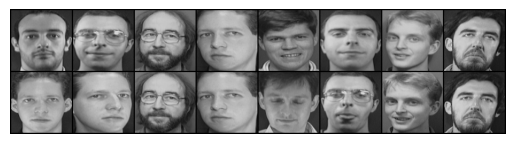

In [9]:
## create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

## extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [10]:
## create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        ## setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        ## setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        ## this function will be called for both images
        ## it's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        ## in this function we pass in both images and obtain both vectors
        ## which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

[1. 1. 0. 0. 1. 0. 0. 0.]


In [11]:
## define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      ## calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [12]:
## load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 2.121668815612793

Epoch number 1
 Current loss 0.8542846441268921

Epoch number 2
 Current loss 0.8602033853530884

Epoch number 3
 Current loss 0.7709791660308838

Epoch number 4
 Current loss 0.5051731467247009

Epoch number 5
 Current loss 0.7820949554443359

Epoch number 6
 Current loss 0.5267269015312195

Epoch number 7
 Current loss 0.7267119884490967

Epoch number 8
 Current loss 0.6771056652069092

Epoch number 9
 Current loss 0.7559174299240112

Epoch number 10
 Current loss 0.7528636455535889

Epoch number 11
 Current loss 0.5568434596061707

Epoch number 12
 Current loss 0.4769396483898163

Epoch number 13
 Current loss 0.6035475730895996

Epoch number 14
 Current loss 0.5219402313232422

Epoch number 15
 Current loss 0.57666015625

Epoch number 16
 Current loss 0.5359817743301392

Epoch number 17
 Current loss 0.44458702206611633

Epoch number 18
 Current loss 0.4210781157016754

Epoch number 19
 Current loss 0.44307011365890503

Epoch number 2

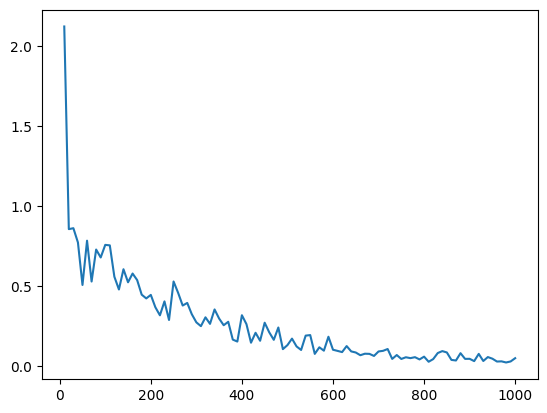

In [14]:
counter = []
loss_history = []
iteration_number= 0

##for  epochs
for epoch in range(100):

    ## for batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        ## send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        ## zero the gradients
        optimizer.zero_grad()

        ## pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        ## pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        ## calculate the backpropagation
        loss_contrastive.backward()

        ## optimize
        optimizer.step()

        ## every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

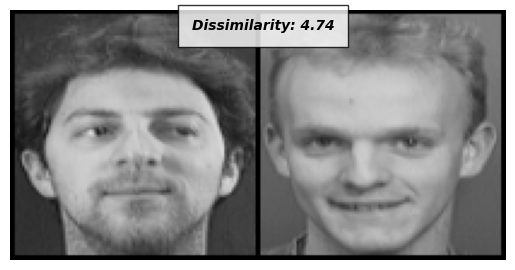

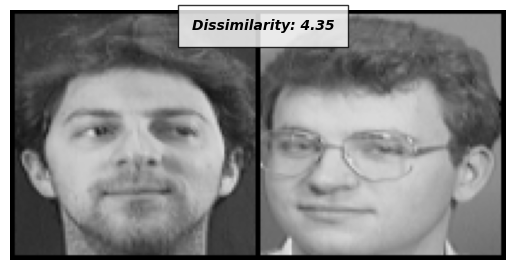

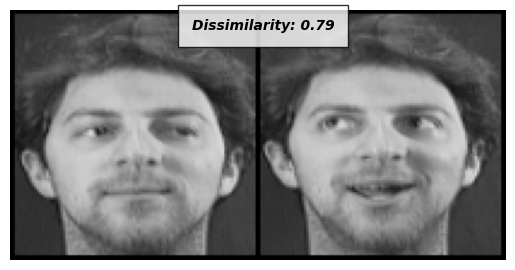

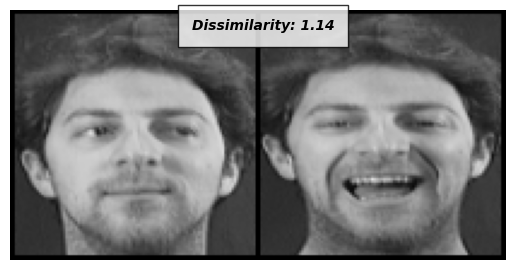

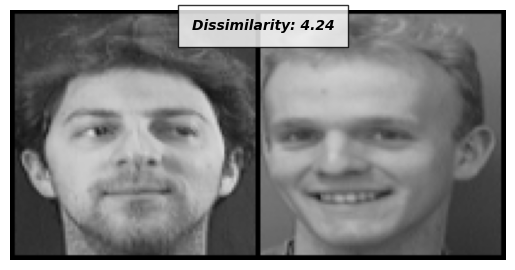

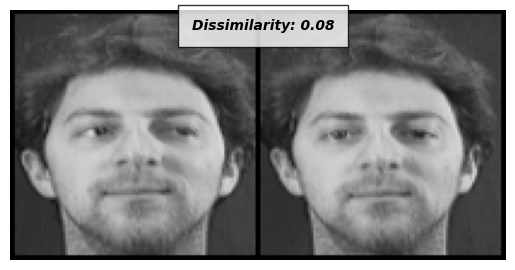

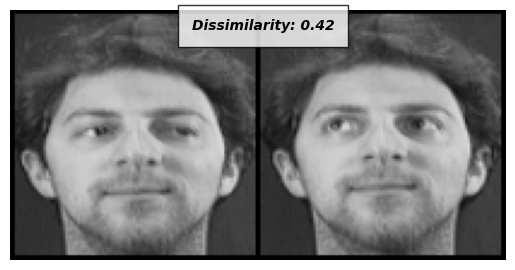

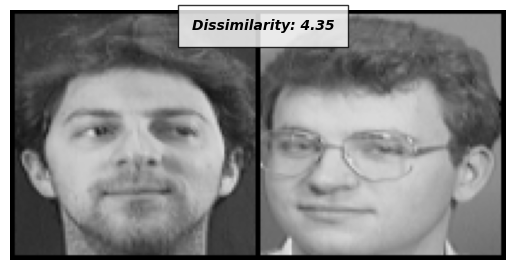

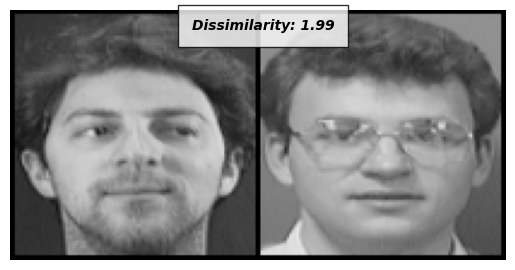

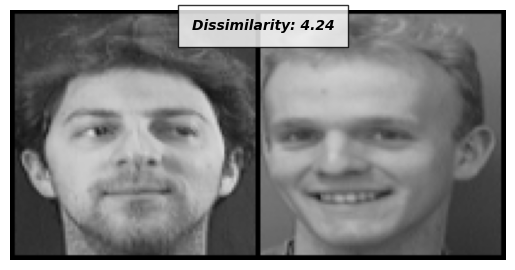

In [15]:
## locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

## grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    ## iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    ## concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')